# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

---------

# 1. Análisis Exploratorio de Datos

## 1.1 Librerías y bases de datos

Importamos las librerías requeridas para el desarrollo del proyecto.

In [4]:
import pandas as pd
import numpy as np 
import prettytable as pt
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [5]:
#Importamos la librería Natural Language Tokenizer
import nltk

#Diccionario de stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))
#Palabras que vamos a mantener en el dataset
stopwords.remove('no')
stopwords.remove('pero')

In [6]:
# Métrica de Evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Modelos de optimización
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# Modelos de machine learning
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron 
from sklearn.linear_model import SGDClassifier 

Importamos las bases de datos: *dev*, *test* y *train* de los reviews de productos de amazon.

In [7]:
dev = pd.read_json('dataset_es_dev.json', lines = True)
test = pd.read_json('dataset_es_test.json', lines = True)
train = pd.read_json('dataset_es_train.json', lines = True)
sets = [dev,test,train]

## 1.2 Exploración general de los datos

Iniciamos revisando los features y tamaño de los diferentes sets de datos.

In [7]:
cols = pt.PrettyTable()
cols.add_column('DEV', dev.columns.tolist())
cols.add_column('TEST', test.columns.tolist())
cols.add_column('TRAIN', train.columns.tolist())
print(cols)

+------------------+------------------+------------------+
|       DEV        |       TEST       |      TRAIN       |
+------------------+------------------+------------------+
|    review_id     |    review_id     |    review_id     |
|    product_id    |    product_id    |    product_id    |
|   reviewer_id    |   reviewer_id    |   reviewer_id    |
|      stars       |      stars       |      stars       |
|   review_body    |   review_body    |   review_body    |
|   review_title   |   review_title   |   review_title   |
|     language     |     language     |     language     |
| product_category | product_category | product_category |
+------------------+------------------+------------------+


In [8]:
sizes = pt.PrettyTable()
sizes.add_column('DEV', dev.shape)
sizes.add_column('TEST', test.shape)
sizes.add_column('TRAIN', train.shape)
print(sizes)

+------+------+--------+
| DEV  | TEST | TRAIN  |
+------+------+--------+
| 5000 | 5000 | 200000 |
|  8   |  8   |   8    |
+------+------+--------+


Como observación inicial revisamos las primeras 5 instancias del dataset *dev* . Donde observamos los id del producto, reviewer y review, la cantidad de estrellas el título y descripción del review, el lenguaje y la categoría del producto.

In [9]:
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


El feature de lenguaje tiene un único valor de *es*, indicando el idioma español. No se usará, así que se elimina.

In [8]:
print(dev['language'].value_counts(),'\n',train['language'].value_counts(),'\n',test['language'].value_counts())
dev.drop(['language'],axis=1,inplace=True)
train.drop(['language'],axis=1,inplace=True)
test.drop(['language'],axis=1,inplace=True)

es    5000
Name: language, dtype: int64 
 es    200000
Name: language, dtype: int64 
 es    5000
Name: language, dtype: int64


Con el objetivo de tener una idea general de los datasets, de los productos y de los promedios en cantidad de estrellas por set de datos para comparar con los resultados finales del modelo de predicción, se desarrollan las siguientes gráficas:

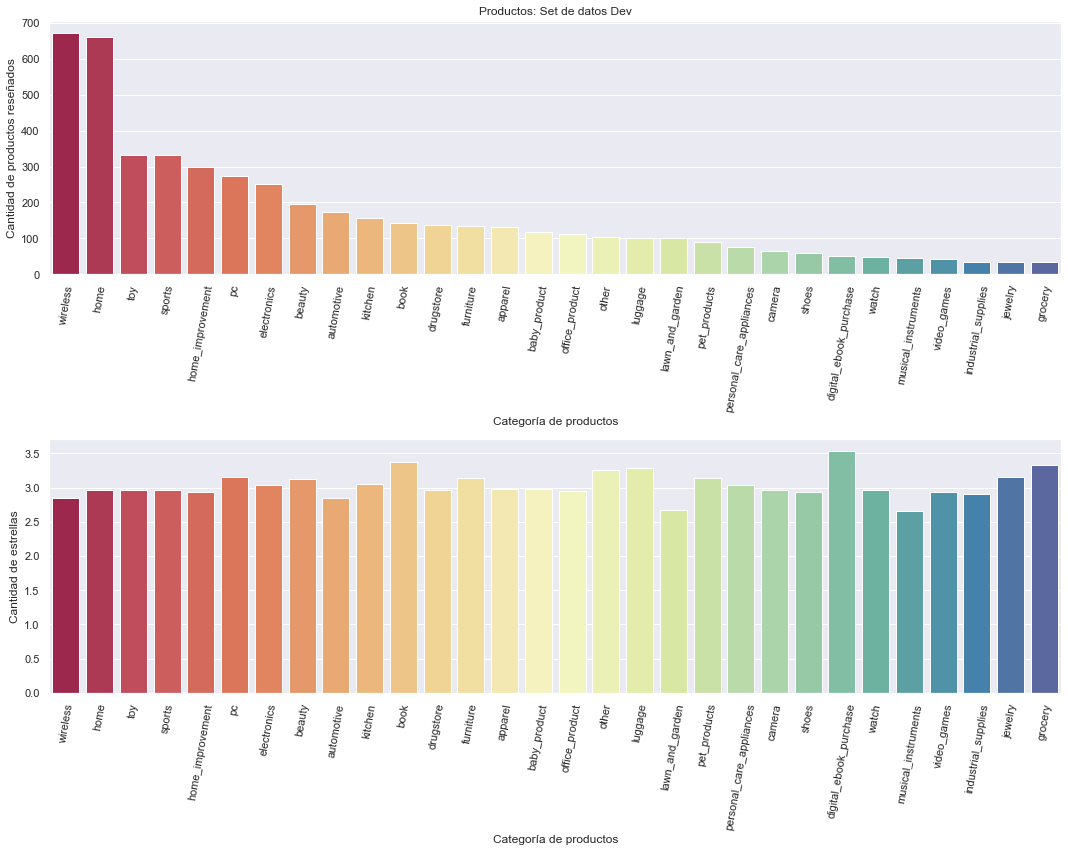

In [11]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
categoria_producto = dev['product_category'].value_counts();
promedio_estrellas = dev.groupby("product_category", as_index=False).mean()


sns.countplot(ax=axes[0], data=dev, x='product_category', palette="Spectral", order=categoria_producto.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Categoría de productos',ylabel='Cantidad de productos reseñados',title='Productos: Set de datos Dev')
sns.barplot(ax=axes[1], x = "product_category", y = "stars", data = promedio_estrellas, palette="Spectral", order=categoria_producto.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Categoría de productos',ylabel='Cantidad de estrellas')
plt.tight_layout();

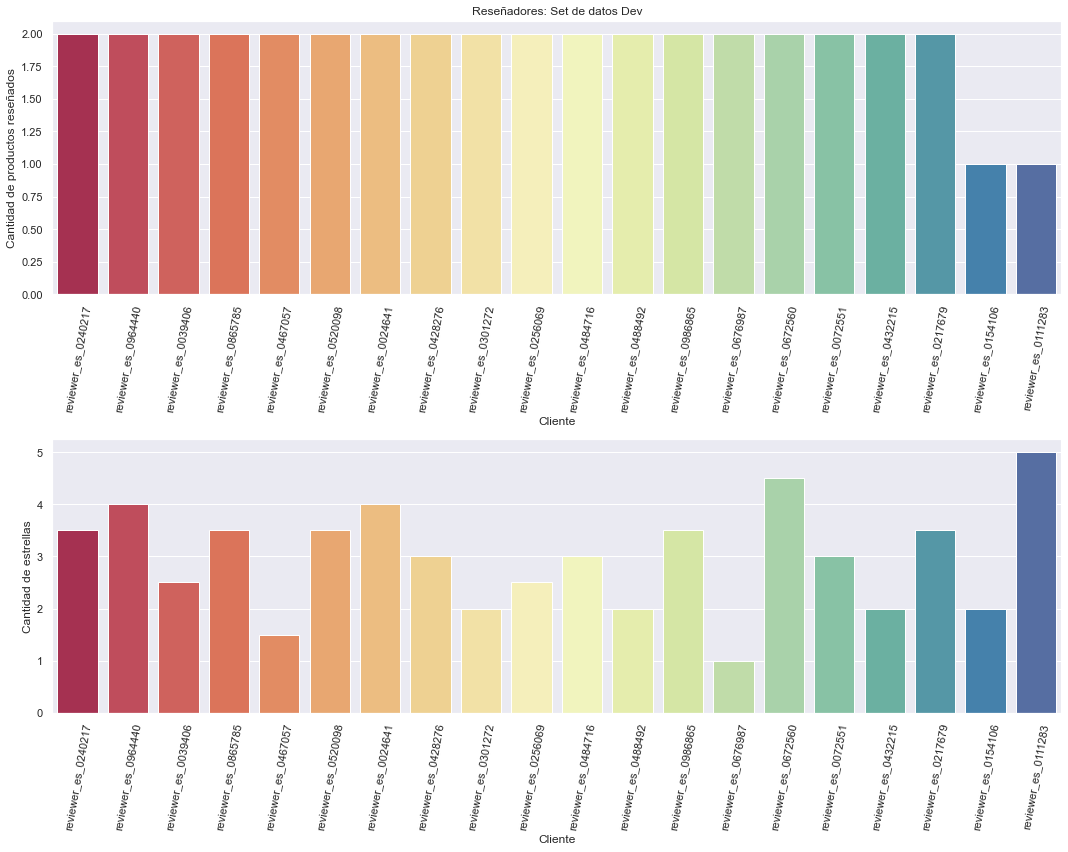

In [12]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
categoria_cliente = dev['reviewer_id'].value_counts()[:20];
promedio_estrellas = dev.loc[dev.reviewer_id.isin(categoria_cliente.index)].groupby("reviewer_id", as_index=False).mean()

sns.countplot(ax=axes[0], data=dev, x='reviewer_id', palette="Spectral", order=categoria_cliente.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Cliente',ylabel='Cantidad de productos reseñados',title='Reseñadores: Set de datos Dev')
sns.barplot(ax=axes[1], x = "reviewer_id", y = "stars", data = promedio_estrellas, palette="Spectral", order=categoria_cliente.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Cliente',ylabel='Cantidad de estrellas')
plt.tight_layout();

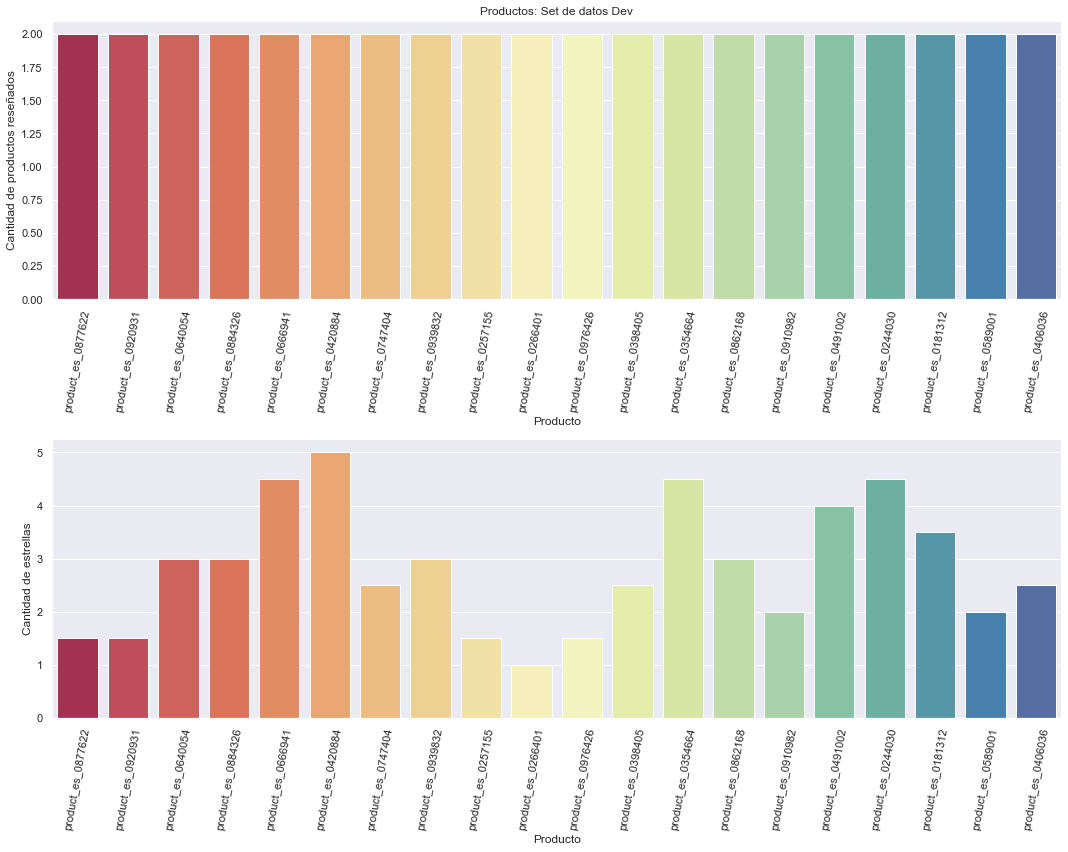

In [13]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
producto = dev['product_id'].value_counts()[:20];
promedio_estrellas = dev.loc[dev.product_id.isin(producto.index)].groupby("product_id", as_index=False).mean()

sns.countplot(ax=axes[0], data=dev, x='product_id', palette="Spectral", order=producto.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Producto',ylabel='Cantidad de productos reseñados',title='Productos: Set de datos Dev')
sns.barplot(ax=axes[1], x = "product_id", y = "stars", data = promedio_estrellas, palette="Spectral", order=producto.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Producto',ylabel='Cantidad de estrellas')
plt.tight_layout();

Como podemos ver, el tipo de producto no tiene un efecto muy fuerte en la puntuación promedio de este, la categoría mejor puntuada en promedio son los eBoooks, cuya calidad es estándar y su puntuacion depende de cuanto le guste al comprador el contenido. Y el reseñador o el producto tampoco son muy relevantes, ya que ambos tienen frecuencia máxima de 2 instancias: no hay reseñadores con alto volumen de reseñas ni positivas ni negativas que podrían afectar el modelo con maneras de escribir específicas a una sola persona, ni productos con muchos reviews que podrian afectar el modelo con palabras específicas a ese producto.

Verificamos la distribución  de estrellas en los set de datos:

In [14]:
dis_stars = pt.PrettyTable()
dis_stars.add_column('Estrellas', [1,2,3,4,5])
dis_stars.add_column('set Dev', dev.stars.value_counts().tolist())
dis_stars.add_column('set Train', train.stars.value_counts().tolist())
dis_stars.add_column('set Test', test.stars.value_counts().tolist())
print(dis_stars)

+-----------+---------+-----------+----------+
| Estrellas | set Dev | set Train | set Test |
+-----------+---------+-----------+----------+
|     1     |   1000  |   40000   |   1000   |
|     2     |   1000  |   40000   |   1000   |
|     3     |   1000  |   40000   |   1000   |
|     4     |   1000  |   40000   |   1000   |
|     5     |   1000  |   40000   |   1000   |
+-----------+---------+-----------+----------+


Las etiquetas están perfectamente distribuidas, indicando que las entradas del modelo van a estar balanceadas.

Finalmente, revisamos la cantidad de palabras que tienen los reviews:

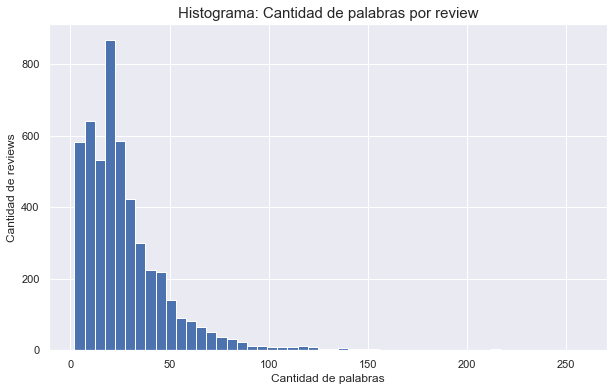

In [15]:
fig = plt.figure(figsize = (10,6))
ax = plt.axes()
words_per_review = dev.review_body.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 50)
ax.set(xlabel='Cantidad de palabras',ylabel='Cantidad de reviews')
plt.title('Histograma: Cantidad de palabras por review', fontsize=15);

In [16]:
print('La cantidad promedio de palabras por review es de:',words_per_review.mean())

La cantidad promedio de palabras por review es de: 27.572


# 2. Procesamiento de Lenguaje Natural

## 2.1. Pre-procesamiento de los datos

Con el fin de normalizar todos los datos para su evaluación se aplica la función *.lower* para que todos los carácteres estén en minúscula y evitar errores en los siguientes pasos.

In [9]:
for set in sets:
    set.review_body = set.review_body.apply(lambda x: x.lower())
    set.review_title = set.review_title.apply(lambda x: x.lower())

In [10]:
test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,estoy muy decepcionado con el vendedor ya que ...,estafa en el envío,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,mi valoración no es sobre el producto sino sob...,estafa de amazon,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,pues tenía interés en este libro y probé la ve...,no conseguí pasar de la portada en kindle,digital_ebook_purchase


Clasificamos los reviews como positivos para los que tienen 4 o 5 estrellas y negativos para los que tienen 3, 2 o 1 estrella.

In [11]:
for set in sets:
    set['binario'] = np.where(set.stars > 3, 1, 0)
    print(set['binario'].value_counts())

0    3000
1    2000
Name: binario, dtype: int64
0    3000
1    2000
Name: binario, dtype: int64
0    120000
1     80000
Name: binario, dtype: int64


## 2.2 Tokenización

Transformamos los reviews mediante un tokenizado para evaluar los comentarios por palabra. Adicionalmente eliminamos caracteres especiales,signos de puntuación, palabras mal escritas, números y emojis.

In [8]:
def limpieza(dataset):

    characters_list = dataset.review_body.apply(lambda x: [each for each in x if not each.isalpha() and each != ' '])
    df_caracteres = []
    for i in range(len(characters_list)):
	    df_caracteres.append(characters_list[i])
    df_caracteres = [item for elem in df_caracteres for item in elem]
    print(np.unique(df_caracteres))

    for character in df_caracteres:
        dataset.review_body = dataset.review_body.apply(lambda x: x.replace(character, ' '))
        dataset.review_title = dataset.review_title.apply(lambda x: x.replace(character, ' '))

    return dataset.review_body, dataset.review_title

In [12]:
def limpieza2(dataset):

    characters_list = dataset.review_body.apply(lambda x: [each for each in x if not each.isalpha() and each != ' '])
    df_caracteres = []
    for i in range(len(characters_list)):
	    df_caracteres.append(characters_list[i])
    df_caracteres = [item for elem in df_caracteres for item in elem]

    sc = np.unique(df_caracteres)
    print(sc)
    dataset.review_body = dataset.review_body.apply(lambda x: ''.join([c for c in x if c not in sc]))
    print('Columna review_body')
    dataset.review_title = dataset.review_title.apply(lambda x: ''.join([c for c in x if c not in sc]))
    print('Columna review_title')
    
    return dataset.review_body, dataset.review_title

In [13]:
def tokenizar(df):

	new_df = df[['review_id','stars','binario','review_body','review_title']]

	new_df['body_token'] = new_df.review_body.apply(lambda x: nltk.tokenize.word_tokenize(x))
	new_df['title_token'] = new_df.review_title.apply(lambda x: nltk.tokenize.word_tokenize(x))
	print('Tokenizado')

	for column in ['body_token', 'title_token']:
		for i in range(len(new_df.body_token)):
			#new_df[column][i] = [word for word in new_df[column][i] if word not in characters]
			new_df[column][i] = [word for word in new_df[column][i] if word not in stopwords]
		print('Columna tokenizada')

	return new_df

In [14]:
dev.review_body, dev.review_title = limpieza2(dev)

['!' '"' '#' '%' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3' '4'
 '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '_' '~' '¡' '°' '¿' '”' '…'
 '€' '❤' '️' '😂' '😊' '😌' '😒' '😔' '😡' '😣' '😤' '😬' '😳' '🙈' '🤔' '🤣']
Columna review_body
Columna review_title


In [15]:
dev

,review_id,product_id,reviewer_id,stars,review_body,review_title,product_category,binario
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,malisimo muy grande demasiado aparatoso y mal ...,mala compra,wireless,0
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,no he recibido el pedido no la devolución,no lo he recibido,apparel,0
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,sports,0
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,utilicé las brocas de menor diámetro y se me d...,brocas de mantequilla,home_improvement,0
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,no me gusta su olor a viejo y aspecto malo,no me gusta,beauty,0
...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,me ha encantado la cesta ha llegado impecablet...,guadalupe,home,1
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,desempeña su función correctamente,calidad precio,camera,1
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,me ha encantado la diadema las flores son tal ...,excelente,toy,1
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,a mi me gustan mucho las fundas tpu ya que son...,genial,wireless,1


In [16]:
dev_token = tokenizar(dev)

Tokenizado
Columna tokenizada
Columna tokenizada


Como resultado observamos que las columnas tokenizadas estan conformadas por listas de las palabras representativas de los comentarios, en minúsculas y sin signos de puntuación:

In [17]:
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0417480,1,0,malisimo muy grande demasiado aparatoso y mal ...,mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]"
1,es_0180432,1,0,no he recibido el pedido no la devolución,no lo he recibido,"[no, recibido, pedido, no, devolución]","[no, recibido]"
2,es_0144850,1,0,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,"[buscar, sistema, no, funciona, bien, abrazade...","[no, aprieta, bien, manillar]"
3,es_0339629,1,0,utilicé las brocas de menor diámetro y se me d...,brocas de mantequilla,"[utilicé, brocas, menor, diámetro, doblaron, v...","[brocas, mantequilla]"
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[no, gusta, olor, viejo, aspecto, malo]","[no, gusta]"


## 2.3 Lemmatización

Evaluamos la librería Spacy para realizar la lemmatización:

In [18]:
import spacy
#spacy.prefer_gpu()
nlp = spacy.load("es_core_news_sm")

In [19]:
Lemma_prueba = pd.DataFrame(columns = ['Token','Token Text','Token Pos', 'Token Lemma'])
dev_token['body_lemma'] = dev_token.body_token.apply(lambda x: ' '.join(x))
doc = nlp(dev_token['body_lemma'][2])
for token in doc:
    Lemma_prueba = Lemma_prueba.append({'Token':token, 'Token Text':token.text, 'Token Pos':token.pos_,
    'Token Lemma':token.lemma_}, ignore_index=True)
print(Lemma_prueba)

         Token  Token Text Token Pos Token Lemma
0       buscar      buscar      VERB      buscar
1      sistema     sistema      NOUN     sistema
2           no          no       ADV          no
3     funciona    funciona      VERB   funcionar
4         bien        bien       ADV        bien
5   abrazadera  abrazadera      NOUN  abrazadera
6        lleva       lleva      VERB      llevar
7      agarrar     agarrar      VERB     agarrar
8     manillar    manillar      VERB    manillar
9           no          no       ADV          no
10     aprieta     aprieta      VERB     apretar
11        bien        bien       ADV        bien
12  deslizando  deslizando      VERB    deslizar
13    linterna    linterna      VERB    linterna
14       hacia       hacia       ADP       hacia
15       abajo       abajo       ADV      abajar


In [20]:
dev_token['body_lemma'] = dev_token.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
dev_token['title_lemma'] = dev_token.title_token.apply(lambda x: ' '.join(x))
dev_token['title_lemma'] = dev_token.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

In [21]:
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0417480,1,0,malisimo muy grande demasiado aparatoso y mal ...,mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]","[malisimo, grande, demasiar, aparatoso, mal, p...","[malo, comprar]"
1,es_0180432,1,0,no he recibido el pedido no la devolución,no lo he recibido,"[no, recibido, pedido, no, devolución]","[no, recibido]","[no, recibir, pedir, no, devolución]","[no, recibir]"
2,es_0144850,1,0,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,"[buscar, sistema, no, funciona, bien, abrazade...","[no, aprieta, bien, manillar]","[buscar, sistema, no, funcionar, bien, abrazad...","[no, apretar, bien, manillar]"
3,es_0339629,1,0,utilicé las brocas de menor diámetro y se me d...,brocas de mantequilla,"[utilicé, brocas, menor, diámetro, doblaron, v...","[brocas, mantequilla]","[utilizar, broca, menor, diámetro, doblar, var...","[broca, mantequilla]"
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[no, gusta, olor, viejo, aspecto, malo]","[no, gusta]","[no, gustar, olor, viejo, aspecto, malo]","[no, gustar]"


## 2.4 Análisis de Frecuencia de las palabras

De acuerdo con el procesamiento anterior obtenemos una primera versión de la frecuencia de palabras que en general determinan si un comentario es positivo o negativo respecto a la clasficación propuesta. Para analizar desarrollamos las gráficas de frecuencia:

In [22]:
#Función de frecuencias de las palabras
def get_freqs(df,columna,titulo):

	# Guardamos todos los titulos y reseñas buenos y malos en listas separadas
	df_malos = df.loc[df.stars.isin([1,2,3])]
	df_buenos = df.loc[df.stars.isin([4,5])]
	df_malos.reset_index(inplace= True)
	df_buenos.reset_index(inplace= True)

	# Guardamos todos los titulos y reseñas buenos y malos en listas separadas
	df_malos_lista = []
	for i in range(len(df_malos.review_title)):
		df_malos_lista.append(df_malos[columna][i])
	df_malos_lista = [item for elem in df_malos_lista for item in elem]

	df_buenos_lista = []
	for i in range(len(df_buenos.review_title)):
		df_buenos_lista.append(df_buenos[columna][i])
	df_buenos_lista = [item for elem in df_buenos_lista for item in elem]

	# Hacemos 4 dataframes con las frecuencias de las palabras
	df_malos_lista_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_malos_lista), orient = 'index')
	df_malos_lista_freq['word'] = df_malos_lista_freq.index
	df_malos_lista_freq.sort_values(by = 0, ascending= False, inplace = True)

	df_buenos_lista_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_buenos_lista), orient = 'index')
	df_buenos_lista_freq['word'] = df_buenos_lista_freq.index
	df_buenos_lista_freq.sort_values(by = 0, ascending= False, inplace = True)

	#Gráfica
	plt.figure(figsize= (8,4))
	plt.subplot(121)
	sns.barplot(x = df_malos_lista_freq[0][:10], y = df_malos_lista_freq.word[:10])
	plt.title(titulo + ': negativo')
	plt.xlabel('Cantidad')
	plt.subplot(122)
	sns.barplot(x = df_buenos_lista_freq[0][:10], y = df_buenos_lista_freq.word[:10])
	plt.title(titulo + ': positivo')
	plt.xlabel('Cantidad')
	plt.tight_layout();
	plt.show()

	return 

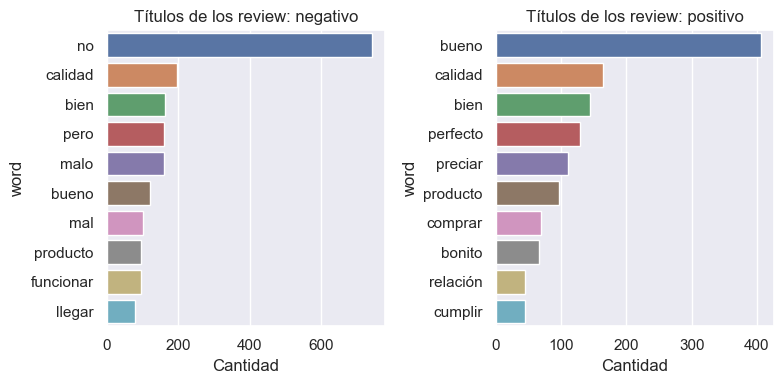

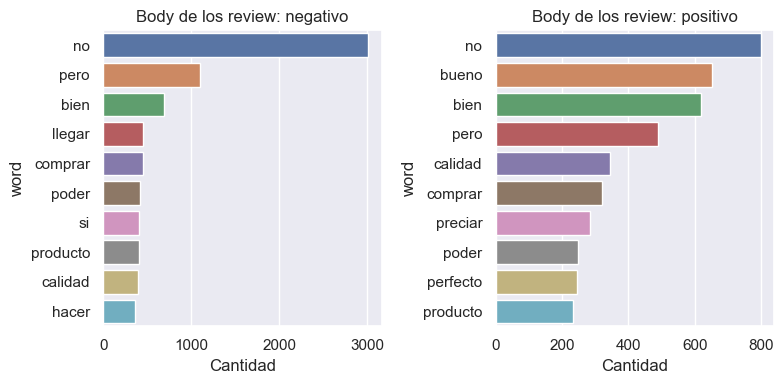

In [20]:
get_freqs(dev_token,'title_lemma','Títulos de los review')
get_freqs(dev_token,'body_lemma','Body de los review')

Las gráficas demuestran que hay muchas palabras que son muy comunes en todos los reviews y que se repiten tanto en los comentarios positivos como en los negativos como por ejemplo *calidad*, *producto* y *bien*. Por tanto, se decide eliminar algunas de las palabras más repetidas en todos los comentarios para evaluar unicamente las palabras representativas que permitan realizar la clasificación.

In [23]:
all_lemmas = []
for i in range(len(dev_token.body_lemma)):
	all_lemmas.append(dev_token.body_lemma[i])
all_lemmas = [item for elem in all_lemmas for item in elem]

one_percentile = int(len(np.unique(all_lemmas)) * 0.01)

#1% de las palabras más comunes del dataset
from collections import Counter
count_freq = Counter(all_lemmas).most_common(one_percentile)
count_notfreq = Counter(all_lemmas).most_common()[-one_percentile:]

Del vector de palabras frecuentes se eliminan algunas que después de algunas pruebas se consideran fundamentales en le predicción.

In [24]:
a_remover = [word for word,val in count_freq] + [word for word,val in count_notfreq]
no_remover = ['bien', 'bueno','perfecto','malo','problema','tiempo','mal','encantar','perfectamente','no','mejor']
for i in no_remover:
    if i in a_remover:
        a_remover.remove(i)

In [25]:
#Código para remover las palabras
dev_token['title_lemma_rm'] = dev_token.title_lemma.apply(lambda x: [word for word in x if word not in a_remover])
dev_token['body_lemma_rm'] = dev_token.body_lemma.apply(lambda x: [word for word in x if word not in a_remover])

De forma que las nuevas gráficas resultante son las siguientes:

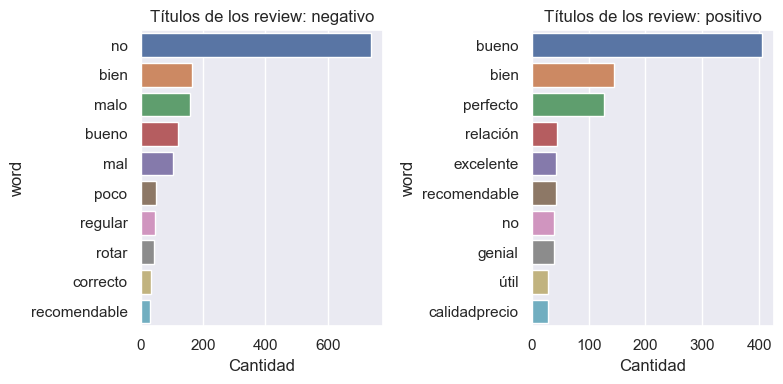

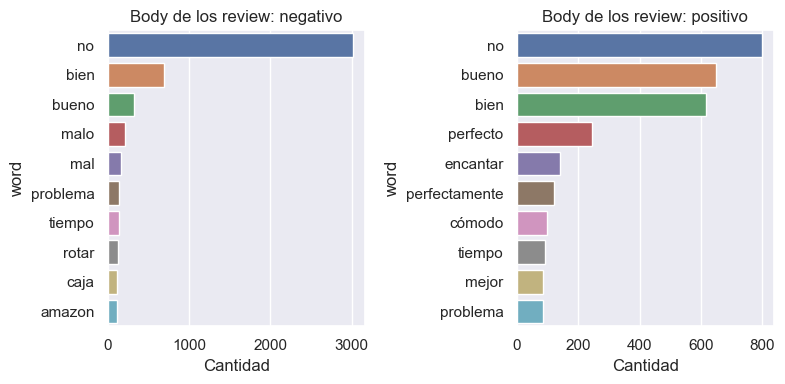

In [26]:
get_freqs(dev_token,'title_lemma_rm','Títulos de los review')
get_freqs(dev_token,'body_lemma_rm','Body de los review')

Verificamos que se eliminan las palabras más comunes que no aportaban información valiosa a la clasificación y nos quedamos con palabras más significativas como: *recomendable* o *útil* para comentarios positivos, y *defectuoso* o *devolver* para comentarios negativos. 

Sumaremos las palabras del titulo a las del cuerpo para tenerlas todas en un mismo feature. 

In [27]:
dev_token['words'] = dev_token['title_lemma'] + dev_token['body_lemma']
dev_token['words_rm'] = dev_token['title_lemma_rm'] + dev_token['body_lemma_rm']
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma,title_lemma_rm,body_lemma_rm,words,words_rm
0,es_0417480,1,0,malisimo muy grande demasiado aparatoso y mal ...,mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]","[malisimo, grande, demasiar, aparatoso, mal, p...","[malo, comprar]",[malo],"[malisimo, aparatoso, mal, protector]","[malo, comprar, malisimo, grande, demasiar, ap...","[malo, malisimo, aparatoso, mal, protector]"
1,es_0180432,1,0,no he recibido el pedido no la devolución,no lo he recibido,"[no, recibido, pedido, no, devolución]","[no, recibido]","[no, recibir, pedir, no, devolución]","[no, recibir]","[no, recibir]","[no, recibir, no, devolución]","[no, recibir, no, recibir, pedir, no, devolución]","[no, recibir, no, recibir, no, devolución]"
2,es_0144850,1,0,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,"[buscar, sistema, no, funciona, bien, abrazade...","[no, aprieta, bien, manillar]","[buscar, sistema, no, funcionar, bien, abrazad...","[no, apretar, bien, manillar]","[no, apretar, bien, manillar]","[buscar, sistema, no, bien, abrazadera, agarra...","[no, apretar, bien, manillar, buscar, sistema,...","[no, apretar, bien, manillar, buscar, sistema,..."
3,es_0339629,1,0,utilicé las brocas de menor diámetro y se me d...,brocas de mantequilla,"[utilicé, brocas, menor, diámetro, doblaron, v...","[brocas, mantequilla]","[utilizar, broca, menor, diámetro, doblar, var...","[broca, mantequilla]","[broca, mantequilla]","[utilizar, broca, menor, diámetro, doblar, var...","[broca, mantequilla, utilizar, broca, menor, d...","[broca, mantequilla, utilizar, broca, menor, d..."
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[no, gusta, olor, viejo, aspecto, malo]","[no, gusta]","[no, gustar, olor, viejo, aspecto, malo]","[no, gustar]",[no],"[no, olor, viejo, aspecto, malo]","[no, gustar, no, gustar, olor, viejo, aspecto,...","[no, no, olor, viejo, aspecto, malo]"


Con el dataset tokenizado, utilizaremos el título y cuerpo de los reviews para realizar modelos que los clasifiquen inicialmente de manera binaria, de forma que sea más sencillo identificar errores y mejoras en la sección de pre-procesamiento y obtener el mejor modelo posible por clasificación binaria como benchmark. Posteriormente continuaremos con los modelos de clasificación para las 5 estrellas. 

Para lo anterior definimos las palabras como vectores usando la estrategia Bag of Words que guarda para cada entrada un vector donde todas las palabras del corpus son una variable y el numero que la funcion le asigna es las veces que aparece en la reseña particular.

Transformamos el dataset asi:

In [28]:
#dev_token = pd.read_csv('dataset_dev_token.csv')
data = dev_token[['words','words_rm','stars','binario']]
data['words_joint'] = data.words.apply(lambda x: ' '.join(x))
data['words_joint_rm'] = data.words_rm.apply(lambda x: ' '.join(x))

In [29]:
data.head()

,words,words_rm,stars,binario,words_joint,words_joint_rm
0,"[malo, comprar, malisimo, grande, demasiar, ap...","[malo, malisimo, aparatoso, mal, protector]",1,0,malo comprar malisimo grande demasiar aparatos...,malo malisimo aparatoso mal protector
1,"[no, recibir, no, recibir, pedir, no, devolución]","[no, recibir, no, recibir, no, devolución]",1,0,no recibir no recibir pedir no devolución,no recibir no recibir no devolución
2,"[no, apretar, bien, manillar, buscar, sistema,...","[no, apretar, bien, manillar, buscar, sistema,...",1,0,no apretar bien manillar buscar sistema no fun...,no apretar bien manillar buscar sistema no bie...
3,"[broca, mantequilla, utilizar, broca, menor, d...","[broca, mantequilla, utilizar, broca, menor, d...",1,0,broca mantequilla utilizar broca menor diámetr...,broca mantequilla utilizar broca menor diámetr...
4,"[no, gustar, no, gustar, olor, viejo, aspecto,...","[no, no, olor, viejo, aspecto, malo]",1,0,no gustar no gustar olor viejo aspecto malo,no no olor viejo aspecto malo


# 3. Métricas de Evaluación


Definimos las métricas de *accuracy, f1_score y matriz de confusión* para evaluar los modelos.

In [30]:
def error(nombre, modelo, X_train, y_train, X_test, y_test, y_pred):
    
    # Data Frame para guardar los resultados
    errores = pd.DataFrame(columns = ['Modelo','Accuracy','f1_score', 'VP', 'VN','FP', 'FN'])

    accuracy = accuracy_score(y_test, y_pred)
    f1_sco = f1_score(y_test, y_pred, average='binary')

    names= ["Positivo", "Negativo"]
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(4,4))
    sns.heatmap(cm,annot=True, fmt=".0f",ax=ax, cmap='Blues')
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    vn, fp, fn, vp = confusion_matrix(y_test, y_pred).ravel()
    errores = errores.append({'Modelo':nombre,'Accuracy':accuracy,'f1_score':f1_sco, 'VP':vp, 'VN':vn,'FP':fp, 'FN':fn},  ignore_index=True)

    return errores

In [31]:
def errores_reviews(y_test, y_pred, dev_token, columna):
    errores_pos = []
    errores_neg = []
    errores_total = []
    for i in range(1500):
        #print(y_test.iloc[i], y_pred[i])
        if y_test.iloc[i] != y_pred[i]:
            if y_test.iloc[i] == 0:
                errores_neg.append(y_test.index[i])
                errores_total.append(y_test.index[i])
            else:
                errores_pos.append(y_test.index[i])
                errores_total.append(y_test.index[i])
    datos_pos = dev_token.loc[dev_token.index.isin(errores_pos),['review_title','review_body',columna]]
    datos_neg = dev_token.loc[dev_token.index.isin(errores_neg),['review_title','review_body',columna]] 
    print('Errores por cantidad de estrellas:')
    print(dev_token.loc[errores_total].groupby('stars').words.count())
    return datos_pos, datos_neg

In [85]:
def error5(nombre, modelo, X_train, y_train, X_test, y_test, y_pred, dev_token):
    
    # Data Frame para guardar los resultados
    errores5 = pd.DataFrame(columns = ['Modelo','Accuracy','Errores 1','Errores 2','Errores 3','Errores 4','Errores 5'])
    accuracy = modelo.score(X_test,y_test)

    #names= y_train.unique().tolist()
    names= ["1","2","3","4","5"]
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(3,3))
    sns.heatmap(cm,annot=True,fmt=".0f",ax=ax, cmap='Blues')
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    errores_total = []
    for i in range(len(y_test)):
        #print(y_test.iloc[i], y_pred[i])
        if y_test.iloc[i] != y_pred[i]:
            errores_total.append(y_test.index[i])

    e_stars = dev_token.loc[errores_total].groupby('stars').words.count()

    errores5 = errores5.append({'Modelo':nombre,'Accuracy':accuracy,'Errores 1':e_stars.iloc[0],'Errores 2':e_stars.iloc[1],
    'Errores 3':e_stars.iloc[2],'Errores 4':e_stars.iloc[3],'Errores 5':e_stars.iloc[4]},  ignore_index=True)

    return errores5

# 4. Modelos de Machine Learning Binarios 

Ahora, a partir de los resultados procesados y organizados, procedemos a aplicar los modelos de Machine Learning para obtener la clasificación y número de estrellas por comentario.

Iniciaremos estableciendo como Benchmark el modelo que mejor clasifique los reviews de manera binaria: buenos o malos. Para esto evaluaremos un random forest y una regresión logística, utilizando el dataset tokenizado y la columna binario previamente establecida en la que 4 y 5 estrellas hacen un buen review y 1, 2 o 3 hacen uno malo.

## 4.1 Dataset Tokenizado

In [33]:
vectorizador=CountVectorizer(lowercase = False)

# Para los datos sin remover palabras
data_vec = vectorizador.fit_transform(data.words_joint)
X_data = data_vec.toarray()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_data, data['binario'], test_size = 0.3, random_state=42)

### 4.1.1 Random Forest Classifier

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


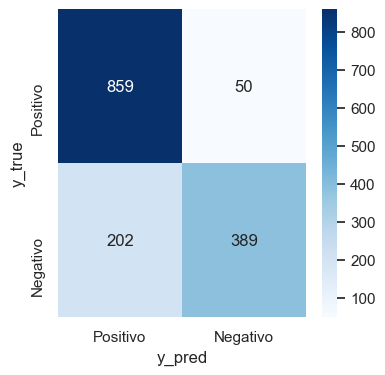

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832,0.75534,389,859,50,202


In [35]:
#params = {'n_estimators': [50,100,150,200], 'max_depth': [10,15,30,45]}
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)

errores = error('Random Forest Tokenizado', best_rf, X_train, y_train, X_test, y_test, y_pred)
errores

**Evaluación de los reviews mal predichos:**

In [36]:
datos_pos, datos_neg = errores_reviews(y_test, y_pred, dev_token, 'words_rm')

Errores por cantidad de estrellas:
stars
1      1
2      7
3     42
4    129
5     73
Name: words, dtype: int64


In [37]:
print('Reviews positivos calificados como negativos:')
datos_pos.head()

Reviews positivos calificados como negativos:


,review_title,review_body,words_rm
3006,bastante completo,no me gusta las instrucciones en ingles,"[completar, no, instrucción, ingle]"
3007,cobran mucho por el envio,llego bien pero el último día tardo casi una s...,"[cobrar, envio, bien, último, tardar, casi, se..."
3017,su ligereza,que es muy ligero aunque un poco bajo y el ple...,"[ligereza, ligero, bajar, plegar, complicar, n..."
3024,ocupa poco y la ranura es amplia,la tengo hace menos de un mes y me gusta pero ...,"[ocupar, ranurar, amplio, mes, creer, caro, re..."
3027,el frigorífico es perfecto el color silver no ...,el frigorífico es perfecto el color silver no ...,"[frigorífico, perfecto, color, silver, no, rea..."


In [38]:
print('Reviews negativos calificados como positivos:')
datos_neg.head()

Reviews negativos calificados como positivos:


,review_title,review_body,words_rm
259,entrega tarde,producto perfecto entrega con seur nefastalleg...,"[entregar, tardar, perfecto, entregar, seur, n..."
1023,un poco disgustada,estaba muy ilusionada porque a mi marido siemp...,"[disgustar, ilusionar, maridar, siempre, zippo..."
1420,bien,es muy mono relación calidad precio buena aunq...,"[bien, mono, relación, bueno, no, maravilloso]"
1557,antonio aguilar,el paquete es el que pedí está en perfecto est...,"[antonio, aguilar, paquete, perfecto, fecho, e..."
1598,calidadprecio perfecto pero ha llegado dañado,el álbum genial en relación calidadprecio pero...,"[calidadprecio, perfecto, dañar, álbum, genial..."


A partir de este primer modelo y la revisión de los errores, identificamos las palabras a eliminar y mantener de la sección 2.4. Por ejemplo, obtuvimos mejores resultados manteniendo la palabra 'no' que quitándola, manteniendo palabras como 'perfecto', 'mal y 'bueno' y eliminando palabras como 'pero'.

La mayor cantidad de errores de predicción se da en los reviews con 4 estrellas, ya que aunque los comentarios son buenos incluyen palabras de queja respecto a algún detalle que molestó al cliente, y estas palabras son consideradas por el modelo como elementos negativos que clasifican en general el review como negativo.

In [49]:
# words_per_review_general = dev.review_body.apply(lambda x: len(x.split(' ')))
# words_per_review_malos = reviews_datos_neg.review_body.apply(lambda x: len(x.split(' ')))
# words_per_review_buenos = reviews_datos_pos.review_body.apply(lambda x: len(x.split(' ')))

In [50]:
# plt.figure(figsize = (10,6))
# sns.distplot(words_per_review_general, kde=True, label = 'General')
# sns.distplot(words_per_review_malos, kde=True, label = 'Negativos')
# sns.distplot(words_per_review_buenos, kde=True, label = 'Positivo')
# plt.legend()
# plt.title('¿Cantidad de palabras por review', fontsize=15);

La longitud de las reviews es muy similar en todo el corpus y en las que clasifica mal, no se puede afirmar que este sea un factor relevante

### 4.1.2 Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.09)


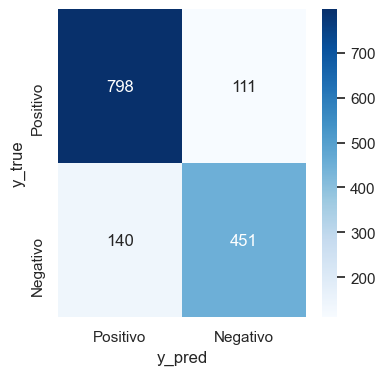

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140


In [39]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0.01, 0.095, 0.09,0.08,0.07,0.06]}
params = {'penalty': ['l1'],'tol': [0.09]}

lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)

print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)

errores = errores.append(error('Regresión Logística Tokenizado', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

In [40]:
datos_pos, datos_neg = errores_reviews(y_test, y_pred, dev_token, 'words_rm')

Errores por cantidad de estrellas:
stars
1     9
2    18
3    84
4    91
5    49
Name: words, dtype: int64


Miramos para estos dos predictores, los reviews que fueron difíciles de predecir para ambos. Desde ya vemos que 3 y 4 estrellas fueron los peor predichos en sus grupos respectivos para ambos modelos, pero que la mayoria de errores está en la categoria de buenos reviews. Exploramos más a continuación:

In [41]:
print('Reviews positivos calificados como negativos:')
datos_pos.head()

Reviews positivos calificados como negativos:


,review_title,review_body,words_rm
3006,bastante completo,no me gusta las instrucciones en ingles,"[completar, no, instrucción, ingle]"
3007,cobran mucho por el envio,llego bien pero el último día tardo casi una s...,"[cobrar, envio, bien, último, tardar, casi, se..."
3017,su ligereza,que es muy ligero aunque un poco bajo y el ple...,"[ligereza, ligero, bajar, plegar, complicar, n..."
3036,muy bonito pero tiene solo una hebilla,pone en la descripción que es de doble hebilla...,"[hebilla, descripción, doblar, hebilla, solame..."
3043,divertido,juego muy entretenido y educativo para toda fa...,"[divertir, jugar, entretener, educativo, todo,..."


In [42]:
print('Reviews negativos calificados como positivos:')
datos_neg.head()

Reviews negativos calificados como positivos:


,review_title,review_body,words_rm
191,libro abandonado,no he podido leerlo no es mi estilo,"[librar, abandonar, no, leerlo, no, estilar]"
254,se levanta,de las unidades ya he gastado porque se leva...,"[levantar, unidad, gastar, levantar, seguir, i..."
259,entrega tarde,producto perfecto entrega con seur nefastalleg...,"[entregar, tardar, perfecto, entregar, seur, n..."
393,no es resistente al agua,he comprado este producto en el mes de febrero...,"[no, resistente, aguar, mes, febrero, mojarse,..."
436,fiasco,me ha durado días muy chulo y la idea es buen...,"[fiasco, chulo, ideo, bueno, horrible]"


Observamos que estos reviews empiezan hablando de positivos antes de luego decir lo que no les gustó del producto. Si la parte positiva del review tiene mayor extensión que la negativa, será muy dificil que el modelo lo clasifique bien. 

### 4.1.3 Complement Naive Bayes

El modelo multinomial Naive Bayes trabaja sobre datasets con varios labels, y  es uno de los tipos de modelo basado en Naive Bayes que se usan clasicamenTe en problemas de clasificación de texto con vecTorizacioned del tipo Bag of Words. Una modificación de este que ha probado tener mejores resultados consistentemente es el modelo Complement Naive Bayes, optimizado para datasets desbalanceados.

Como este último no es nuestro caso, no podemos elegir uno de estos dos modelos sin probarlos ambos, lo hacemos a continuación: 

ComplementNB(alpha=1.7)


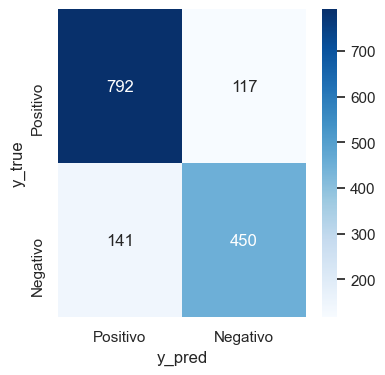

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141


In [43]:
#params = {'alpha': [1.4, 1.5, 1.6, 1.7, 1.8, 1.9], 'norm': [True, False]}
params = {'alpha': [1.7], 'norm': [True, False]}
cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Tokenizado', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

## 4.2 Dataset tokenizado con palabras removidas

In [52]:
vectorizador=CountVectorizer(lowercase = False)

# Para los datos con palabras removidas
data_vec = vectorizador.fit_transform(data.words_joint_rm)
X_data_rm = data_vec.toarray()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_data_rm, data['binario'], test_size = 0.3, random_state=42)

### 4.2.1 Random Forest Classifier

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


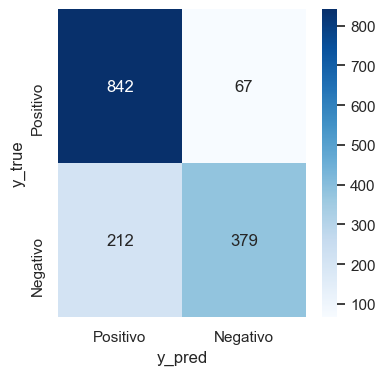

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212


In [46]:
#params = {'n_estimators': [50,,100,150,200], 'max_depth': [10,,15,30,45]}
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)

errores = errores.append(error('Random Forest Removidas', best_rf, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.2.2 Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.09)


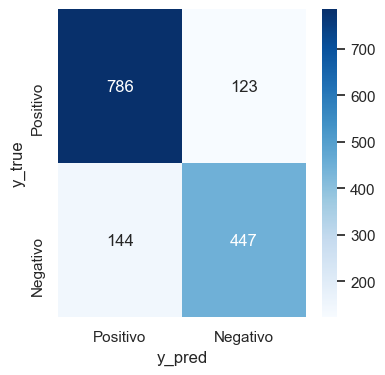

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144


In [55]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0.06,0.07,0.08,0.09,0.095,0.01]}
params = {'penalty': ['l1'],'tol': [0.09]}

lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)

errores = errores.append(error('Regresión Logística Removidas', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.2.3 Naive Bayes Complement NB

ComplementNB(alpha=2.3)


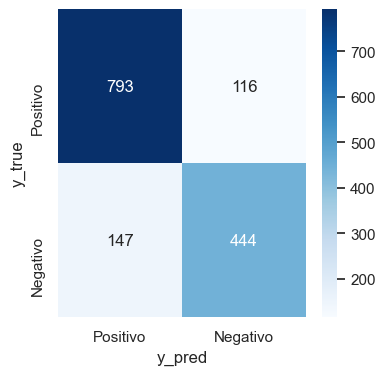

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147


In [48]:
#params = {'alpha': [2.1, 2.2, 2.3, 2.4, 2.5], 'norm': [True, False]}
params = {'alpha': [2.3], 'norm': [True, False]}
		  
cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Removidas', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

## 4.3 Bigramas

Sabemos que el mejor modelo para tokens únicos es un Logistic Regressor con Accuracy de alrededor del 81%, intentaremos mejorar sobre este benchmark usando estos mismos modelos con bigramas en vez de unigramas.

In [56]:
# Generamos el dataset con los bigramas
new_vec = CountVectorizer(analyzer='word', ngram_range=(2, 2))
new_data_vec = new_vec.fit_transform(data.words_joint)
X_data_bi = new_data_vec.toarray()

# Tomamos los bigramas unicos
all_bigrams = new_vec.get_feature_names()
print(len(all_bigrams))

52909


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_data_bi, data['binario'], test_size = 0.3, random_state=42)

### 4.3.1 Random Forest

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


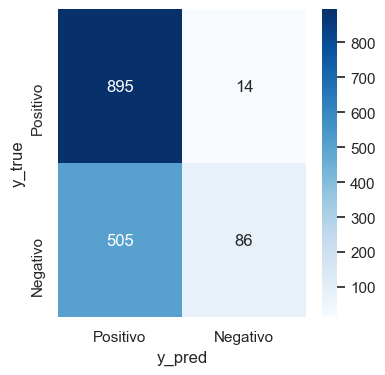

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505


In [58]:
# Utilizamos el mejor estimador Random Forest, con esta nueva data
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)

errores = errores.append(error('Random Forest Bigrama', best_rf, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.3.2. Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.01)


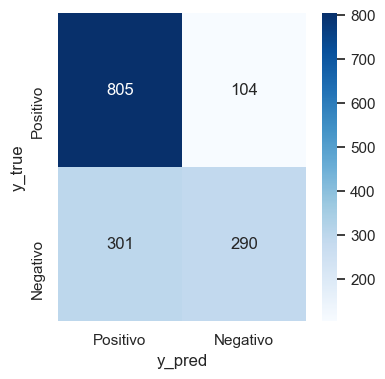

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505


In [59]:
params = {'penalty': ['l1'],'tol': [0.01]}
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)

errores = errores.append(error('Regresión Logística Bigrama', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.3.3 Complement Naive Bayes Complement

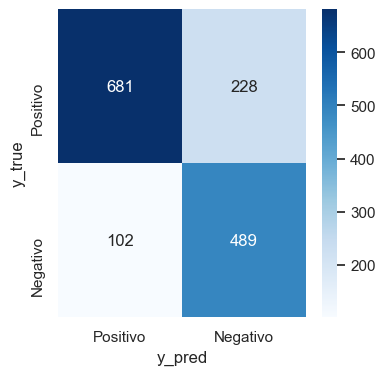

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505


In [60]:
#params = {'alpha': [2.8, 2, 2.1, 2.2, 2.3, 2.4, 2.5], 'norm': [True, False]}
params = {'alpha': [2.8], 'norm': [True, False]}	  
cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Bigrama', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

## 4.4 Dataset con bigrama afirmativo y negativo

Con base en los resultados anteriores, consideramos como mejora al dataset: mantener los datos lemmatizados sin remover las palabras más frecuentes, pero unir las palabras 'no' con la siguiente palabra tokenizada, de forma que obtengamos palabras como; 'nollegar', 'nofuncionar', 'nogustar'.

In [61]:
data['words_no'] = data['words_joint'].apply(lambda x: re.sub('^no\s',' no',x))
data['words_no'] = data['words_no'].apply(lambda x: re.sub('\sno\s',' no',x))
data['words_no'] = data['words_no'].apply(lambda x: re.sub('^si\s',' si',x))
data['words_no'] = data['words_no'].apply(lambda x: re.sub('\ssi\s',' si',x))

In [62]:
vectorizador=CountVectorizer(lowercase = False)
# Para los datos sin remover palabras
data_vec_no = vectorizador.fit_transform(data.words_no)
X_data_no = data_vec_no.toarray()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_data_no, data['binario'], test_size = 0.3, random_state=42)

### 4.4.1 Random Forest

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


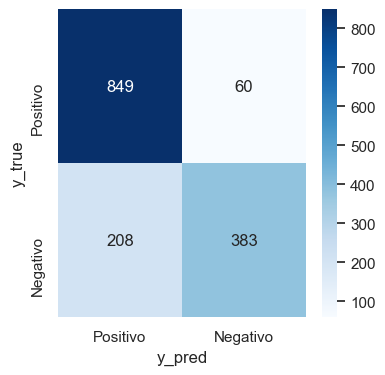

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505


In [64]:
#params = {'n_estimators': [50,,100,150,200], 'max_depth': [10,,15,30,45]}
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)
errores = errores.append(error('Random Forest Bigrama Si/No', best_rf, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.4.2 Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.07)


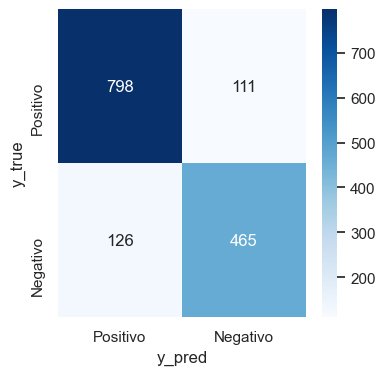

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505


In [65]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0.08, 0.07, 0.0,6, 0.05, 0.04, 0.03, 0.02]}
params = {'penalty': ['l1'],'tol': [0.07]}
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)
errores = errores.append(error('Regresión Logística Bigrama Si/No', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.3.3 Naive Bayes Complement NB

ComplementNB(alpha=1.7)


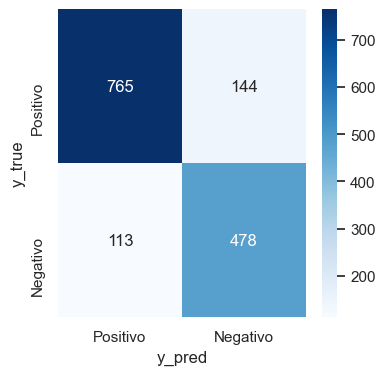

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.832000,0.755340,389,859,50,202
0,Regresión Logística Tokenizado,0.832667,0.782307,451,798,111,140
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777202,450,792,117,141
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.822667,0.771084,448,786,123,143
0,Naive Bayes ComplementNB Removidas,0.824667,0.771503,444,793,116,147
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505
0,Regresión Logística Removidas,0.824000,0.773585,451,785,124,140
0,Regresión Logística Removidas,0.822000,0.770026,447,786,123,144
0,Random Forest Bigrama,0.654000,0.248915,86,895,14,505


In [66]:
#params = {'alpha': [1.3, 1.4, 1.5, 1.6, 1.7, 1.8],'norm': [True, False]}
params = {'alpha': [1.7],'norm': [True, False]}

cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Bigrama Si/No', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

A partir de todos los resultados, datasets y modelos, se aplicaron diferentes técnicas para conseguir mejorar las métricas de los modelos, desde el tokenizado, la organización de las palabras, la lemmatización y los parámetros; de forma que logramos pasar de accuracy de alrededor de 0.65 hasta el mayor accuracy conseguido de 0.84. El modelo con mejores resultados, tanto en el *Accuracy* como en el *f1_score* es la regresión logística con el dataset editado con bigramas para las expresiones con la palabra 'no', demostrando que es uno de los mejores modelos específicamente para datos binarios. 

Para continuar, es necesario aplicar los modelos que predecir la clasificación de las 5 estrellas.

# 5. Modelos de Clasificación de 5 estrellas

A partir de los resultados obtenidos en la clasificación binaria y las correcciones aplicadas al preprocesamiento de datos, procedemos a iniciar con los modelos de clasificación para las 5 estrellas. Empleamos varios modelos diferentes para poder comparar resultados.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_data_no, data['stars'], test_size = 0.3, random_state=42)

## 5.1 Naive Bayes Complement

ComplementNB(alpha=1.8, norm=True)


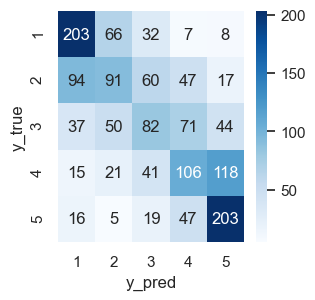

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.456667,113,218,202,195,87


In [91]:
#params = {'alpha': [1.6, 1.7, 1.8, 1.9, 2, 2.2, 2.5],'norm': [True, False]}
params = {'alpha': [1.8],'norm': [True, False]}

cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)
errores5 = error5('Naive Bayes ComplementNB Estrellas', cnb_model, X_train, y_train, X_test, y_test, y_pred, dev_token)
errores5

## 5.2 Random Forest

RandomForestClassifier(max_depth=13, n_estimators=200)


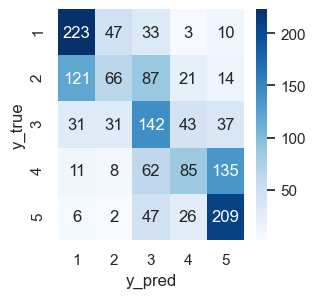

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.456667,113,218,202,195,87
0,Random Forest Estrellas,0.483333,93,243,142,216,81


In [92]:
#params = {'n_estimators': [10, 25, 50, 100, 200],'max_depth': [11,13,15,17]}
params = {'n_estimators': [200],'max_depth': [13]}
rf = GridSearchCV(RandomForestClassifier(), params)
rf.fit(X_train, y_train)
rfo = rf.best_estimator_
print(rfo)
y_pred = rfo.predict(X_test)

errores5 = errores5.append(error5('Random Forest Estrellas', rf, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.3 Ridge Classifier

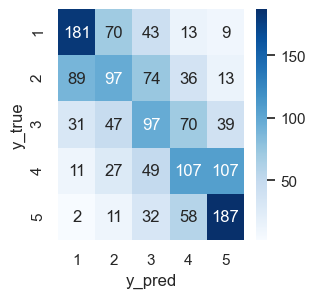

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.456667,113,218,202,195,87
0,Random Forest Estrellas,0.483333,93,243,142,216,81
0,Ridge Estrellas,0.446000,135,212,187,194,103


In [93]:
#Generación del modelo lineal
ridge = RidgeClassifier(solver='sag', tol=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
errores5 = errores5.append(error5('Ridge Estrellas', ridge, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.4 Kneighbors Classifier

KNeighborsClassifier(n_neighbors=18)


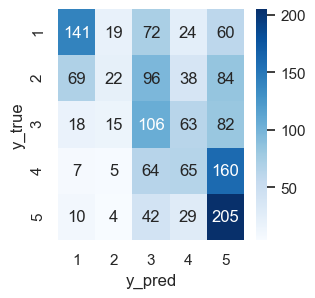

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.456667,113,218,202,195,87
0,Random Forest Estrellas,0.483333,93,243,142,216,81
0,Ridge Estrellas,0.446000,135,212,187,194,103
0,KNN Estrellas,0.349333,176,289,183,244,84
0,KNN Estrellas,0.359333,175,287,178,236,85
0,KNN Estrellas,0.359333,175,287,178,236,85


In [96]:
params = {'n_neighbors' : [16,17,18,19,20,21]}
neigh = GridSearchCV(KNeighborsClassifier(), params)
neigh.fit(X_train, y_train)
neigho = neigh.best_estimator_
print(neigho)
y_pred = neigho.predict(X_test)
errores5 = errores5.append(error5('KNN Estrellas', neigh, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.5 Nearest Centroid

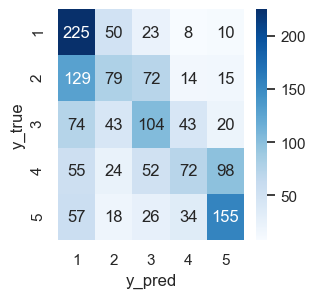

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.456667,113,218,202,195,87
0,Random Forest Estrellas,0.483333,93,243,142,216,81
0,Ridge Estrellas,0.446000,135,212,187,194,103
0,KNN Estrellas,0.349333,176,289,183,244,84
0,KNN Estrellas,0.359333,175,287,178,236,85
0,KNN Estrellas,0.359333,175,287,178,236,85
0,Nearest Centroid Estrellas,0.423333,91,230,180,229,135


In [97]:
centroid = NearestCentroid()
centroid.fit(X_train, y_train)
y_pred = centroid.predict(X_test)
errores5 = errores5.append(error5('Nearest Centroid Estrellas', centroid, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.6 Passive Aggressive Classifier

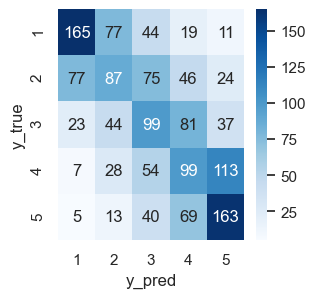

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.456667,113,218,202,195,87
0,Random Forest Estrellas,0.483333,93,243,142,216,81
0,Ridge Estrellas,0.446000,135,212,187,194,103
0,KNN Estrellas,0.349333,176,289,183,244,84
0,KNN Estrellas,0.359333,175,287,178,236,85
0,KNN Estrellas,0.359333,175,287,178,236,85
0,Nearest Centroid Estrellas,0.423333,91,230,180,229,135
0,Passive Agressive Classifier Estrellas,0.408667,151,222,185,202,127


In [98]:
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
y_pred = pac.predict(X_test)

errores5 = errores5.append(error5('Passive Agressive Classifier Estrellas', pac, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

In [ ]:
params = {'penalty' : ['l2','l1','elasticnet'],
		  'alpha' : [0.0001, 0.001, 0.01, 0.1]}
perceptron = GridSearchCV(Perceptron(), params)
perceptron.fit(X_train, y_train)
perceptron = perceptron.best_estimator_
y_pred = perceptron.predict(X_test)

errores5 = errores5.append(error5('Perceptron Estrellas', perceptron, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

In [ ]:
#Se demoró 2.1k segundos .
params = {'penalty' : ['l2','l1','elasticnet'],
		  'alpha' : [0.0001, 0.001, 0.01, 0.1]}
sgd = GridSearchCV(SGDClassifier(), params)
sgd.fit(X_train, y_train)
sgd = sgd.best_estimator_
y_pred = sgd.predict(X_test)

errores5 = errores5.append(error5('SGDClassifier Estrellas', sgd, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

En general, observamos que la mayor cantidad de errores para todos los modelos es para los comentarios con 2 y 4 estrellas, seguramente debido a que pueden confundirse con comentarios muy malos de 1 estrella o muy buenos de 5 estrellas.

El modelo con mejores resultados es el Random Forest con 0.48 de accuracy, 3 décimas mayor al segundo puesto que es el modelo de Naive Bayes ComplementNB.

# 6. Modelo Final

## 6.1. Preprocesamiento del dataset Train

In [166]:
mini_train = train.sample(20000)
mini_train.reset_index(inplace = True)
mini_train.stars.value_counts()

4    4058
5    4037
1    3976
3    3966
2    3963
Name: stars, dtype: int64

In [167]:
mini_train.review_body, mini_train.review_title = limpieza2(mini_train)

['!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2'
 '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '[' ']' '^' '_' '`'
 '{' '¡' '°' '¿' '×' '\u200d' '“' '”' '…' '€' '☹' '☺' '♀' '❤' '️' '\ufeff'
 '🏻' '🏼' '👋' '👌' '👍' '👎' '😁' '😂' '😄' '😅' '😉' '😊' '😌' '😍' '😏' '😒' '😔' '😕'
 '😖' '😞' '😠' '😡' '😢' '😣' '😥' '😬' '😭' '🤔' '🤣' '🤦' '🤨' '🤮' '🥰']
Columna review_body
Columna review_title


In [168]:
train_token = tokenizar(mini_train)
train_token.head()

Tokenizado
Columna tokenizada
Columna tokenizada


,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0784550,5,1,sennheiser es buena marca además duran mucho m...,lo mejor a este precio,"[sennheiser, buena, marca, además, duran, auri...","[mejor, precio]"
1,es_0076344,3,0,no he descubierto grandes novedades que no hic...,ni fu ni fa,"[no, descubierto, grandes, novedades, no, hici...","[fu, fa]"
2,es_0204940,2,0,pensaba por los comentarios que vendrían las b...,no es lo que esperaba,"[pensaba, comentarios, vendrían, boquillas, pl...","[no, esperaba]"
3,es_0218147,3,0,son poco pequeñas tengo unas nimbus en el mism...,pequeñas,"[pequeñas, unas, nimbus, mismo, número, media,...",[pequeñas]
4,es_0530087,4,1,el fabricante solicita una factura de la compr...,garantia,"[fabricante, solicita, factura, compra, garant...",[garantia]


In [169]:
def lemmatizar(dataset):
    dataset['body_lemma'] = dataset.body_token.apply(lambda x: ' '.join(x))
    dataset['body_lemma'] = dataset.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
    print('Body lematizado')
    dataset['title_lemma'] = dataset.title_token.apply(lambda x: ' '.join(x))
    dataset['title_lemma'] = dataset.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
    print('Title lematizado')

    return dataset

In [170]:
train_token = lemmatizar(train_token)
train_token.head()

Body lematizado
Title lematizado


,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0784550,5,1,sennheiser es buena marca además duran mucho m...,lo mejor a este precio,"[sennheiser, buena, marca, además, duran, auri...","[mejor, precio]","[sennheiser, bueno, marcar, además, durar, aur...","[mejor, preciar]"
1,es_0076344,3,0,no he descubierto grandes novedades que no hic...,ni fu ni fa,"[no, descubierto, grandes, novedades, no, hici...","[fu, fa]","[no, descubrir, grande, novedad, no, hacer, ad...","[fu, fa]"
2,es_0204940,2,0,pensaba por los comentarios que vendrían las b...,no es lo que esperaba,"[pensaba, comentarios, vendrían, boquillas, pl...","[no, esperaba]","[pensar, comentario, venir, boquilla, plástico...","[no, esperar]"
3,es_0218147,3,0,son poco pequeñas tengo unas nimbus en el mism...,pequeñas,"[pequeñas, unas, nimbus, mismo, número, media,...",[pequeñas],"[pequeño, uno, nimbus, mismo, número, medio, t...",[pequeño]
4,es_0530087,4,1,el fabricante solicita una factura de la compr...,garantia,"[fabricante, solicita, factura, compra, garant...",[garantia],"[fabricante, solicitar, facturar, comprar, gar...",[garantia]


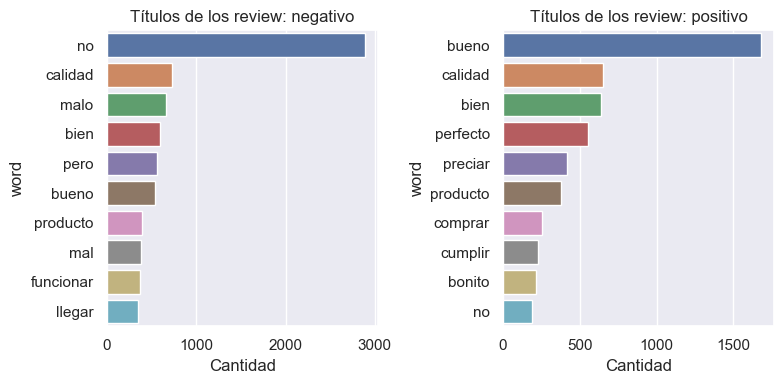

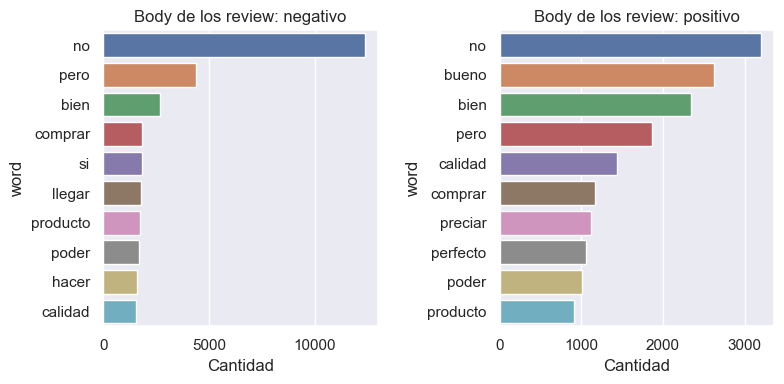

In [171]:
get_freqs(train_token,'title_lemma','Títulos de los review')
get_freqs(train_token,'body_lemma','Body de los review')

In [172]:
train_token['words'] = train_token['title_lemma'] + train_token['body_lemma']
train_token = train_token[['words','stars','binario']]
train_token['words_joint'] = train_token.words.apply(lambda x: ' '.join(x))

In [173]:
train_token['words_no'] = train_token['words_joint'].apply(lambda x: re.sub('^no\s',' no',x))
train_token['words_no'] = train_token['words_no'].apply(lambda x: re.sub('\sno\s',' no',x))
train_token['words_no'] = train_token['words_no'].apply(lambda x: re.sub('^si\s',' si',x))
train_token['words_no'] = train_token['words_no'].apply(lambda x: re.sub('\ssi\s',' si',x))

## 6.2 Preprocesamiento del dataset Test

In [174]:
test.review_body, test.review_title = limpieza2(test)
test_token = tokenizar(test)
test_token.head()

[]
Columna review_body
Columna review_title
Tokenizado
Columna tokenizada
Columna tokenizada


,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0038754,1,0,no me llego el articulo me lo mando por correo...,no me llego,"[no, llego, articulo, mando, correos, normal, ...","[no, llego]"
1,es_0748979,1,0,la mensajería horrible no compro mas,amazon sigue sin cumplir en las entregas,"[mensajería, horrible, no, compro, mas]","[amazon, sigue, cumplir, entregas]"
2,es_0411746,1,0,estoy muy decepcionado con el vendedor ya que ...,estafa en el envío,"[decepcionado, vendedor, pedido, no, llegó, ti...","[estafa, envío]"
3,es_0786686,1,0,mi valoración no es sobre el producto sino sob...,estafa de amazon,"[valoración, no, producto, sino, amazon, ofrec...","[estafa, amazon]"
4,es_0429700,1,0,pues tenía interés en este libro y probé la ve...,no conseguí pasar de la portada en kindle,"[pues, interés, libro, probé, versión, kindle,...","[no, conseguí, pasar, portada, kindle]"


In [175]:
test_token = lemmatizar(test_token)
test_token.head()

Body lematizado
Title lematizado


,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0038754,1,0,no me llego el articulo me lo mando por correo...,no me llego,"[no, llego, articulo, mando, correos, normal, ...","[no, llego]","[no, llegar, articular, mandar, correo, normal...","[no, llegar]"
1,es_0748979,1,0,la mensajería horrible no compro mas,amazon sigue sin cumplir en las entregas,"[mensajería, horrible, no, compro, mas]","[amazon, sigue, cumplir, entregas]","[mensajería, horrible, no, comprar, mas]","[amazon, seguir, cumplir, entregar]"
2,es_0411746,1,0,estoy muy decepcionado con el vendedor ya que ...,estafa en el envío,"[decepcionado, vendedor, pedido, no, llegó, ti...","[estafa, envío]","[decepcionar, vendedor, pedir, no, llegar, tie...","[estafar, enviar]"
3,es_0786686,1,0,mi valoración no es sobre el producto sino sob...,estafa de amazon,"[valoración, no, producto, sino, amazon, ofrec...","[estafa, amazon]","[valoración, no, producto, sino, amazon, ofrec...","[estafar, amazon]"
4,es_0429700,1,0,pues tenía interés en este libro y probé la ve...,no conseguí pasar de la portada en kindle,"[pues, interés, libro, probé, versión, kindle,...","[no, conseguí, pasar, portada, kindle]","[pues, interés, librar, probar, versión, kindl...","[no, conseguir, pasar, portar, kindle]"


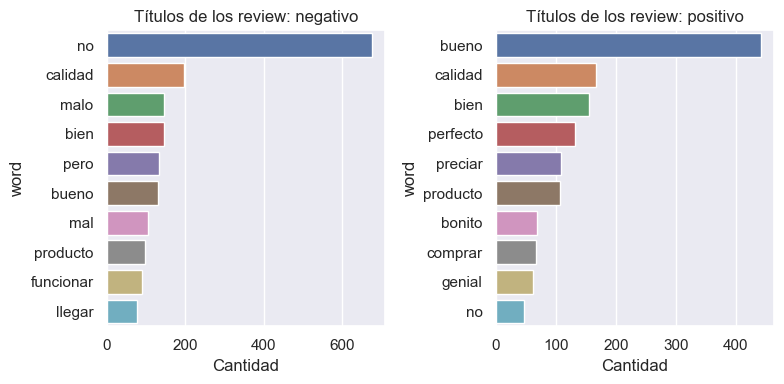

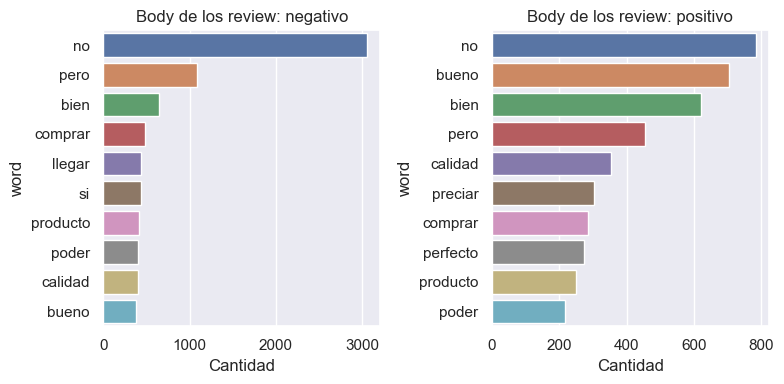

In [176]:
get_freqs(test_token,'title_lemma','Títulos de los review')
get_freqs(test_token,'body_lemma','Body de los review')

In [177]:
test_token['words'] = test_token['title_lemma'] + test_token['body_lemma']
test_token = test_token[['words','stars','binario']]
test_token['words_joint'] = test_token.words.apply(lambda x: ' '.join(x))

In [178]:
test_token['words_no'] = test_token['words_joint'].apply(lambda x: re.sub('^no\s',' no',x))
test_token['words_no'] = test_token['words_no'].apply(lambda x: re.sub('\sno\s',' no',x))
test_token['words_no'] = test_token['words_no'].apply(lambda x: re.sub('^si\s',' si',x))
test_token['words_no'] = test_token['words_no'].apply(lambda x: re.sub('\ssi\s',' si',x))

In [179]:
train_token

,words,stars,binario,words_joint,words_no
0,"[mejor, preciar, sennheiser, bueno, marcar, ad...",5,1,mejor preciar sennheiser bueno marcar además d...,mejor preciar sennheiser bueno marcar además d...
1,"[fu, fa, no, descubrir, grande, novedad, no, h...",3,0,fu fa no descubrir grande novedad no hacer ade...,fu fa nodescubrir grande novedad nohacer adema...
2,"[no, esperar, pensar, comentario, venir, boqui...",2,0,no esperar pensar comentario venir boquilla pl...,noesperar pensar comentario venir boquilla pl...
3,"[pequeño, pequeño, uno, nimbus, mismo, número,...",3,0,pequeño pequeño uno nimbus mismo número medio ...,pequeño pequeño uno nimbus mismo número medio ...
4,"[garantia, fabricante, solicitar, facturar, co...",4,1,garantia fabricante solicitar facturar comprar...,garantia fabricante solicitar facturar comprar...
...,...,...,...,...,...
19995,"[manuel, villalba, tal, describir, bueno, comp...",5,1,manuel villalba tal describir bueno comprar in...,manuel villalba tal describir bueno comprar in...
19996,"[mas, no, gustar, entretener]",2,0,mas no gustar entretener,mas nogustar entretener
19997,"[faltar, filtrar, malo, suerte, venir, filtrar...",2,0,faltar filtrar malo suerte venir filtrar combu...,faltar filtrar malo suerte venir filtrar combu...
19998,"[librar, lectura, valenciano, ﻿1, lugar, indic...",4,1,librar lectura valenciano ﻿1 lugar indicar pet...,librar lectura valenciano ﻿1 lugar indicar pet...


In [180]:
data = pd.concat([train_token.words_no, test_token.words_no])

In [181]:
# Series de resultados y
ybin = mini_train.binario
ystars = mini_train.stars
ybin_test = test_token.binario
ystars_test = test_token.stars

## 6.3 Modelo de Machine Learning Binario

In [182]:
vectorizador = CountVectorizer(lowercase = False)
vec = vectorizador.fit_transform(data)
whole_thing = vec.toarray()
X_train_data = whole_thing[:20000]
X_test_data = whole_thing[-5000:]

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.09)


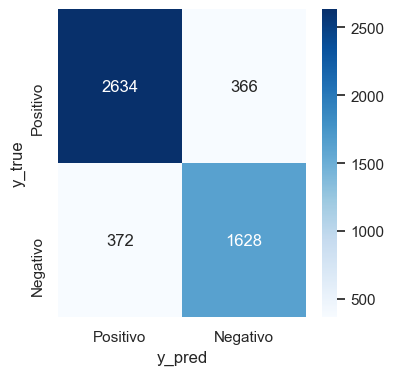

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Validación binaria: Regresión Logística,0.8524,0.815223,1628,2634,366,372


In [183]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0-07,0.08,0.09,0.1,0.11]}
params = {'penalty': ['l1'],'tol': [0.09]}
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train_data, ybin)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test_data)
errores_val = error('Validación binaria: Regresión Logística', best_lr, X_train_data, ybin, X_test_data, ybin_test, y_pred)
errores_val

### 6.4 Modelo de Clasificación de estrellas

RandomForestClassifier(max_depth=12, n_estimators=200)


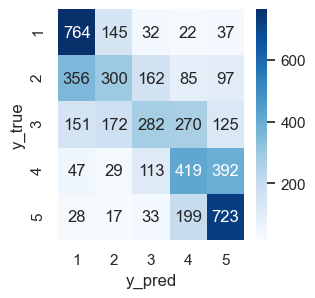

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Random Forest Estrellas Validation,0.4976,503,470,499,544,496


In [184]:
params = {'n_estimators': [200], 'max_depth': [12,13,14]}
rf = GridSearchCV(RandomForestClassifier(), params)
rf.fit(X_train_data, ystars)
rfo = rf.best_estimator_
print(rfo)
y_pred = rfo.predict(X_test_data)
errores_val = error5('Random Forest Estrellas Validation', rfo, X_train_data, ystars, X_test_data, ystars_test, y_pred, train_token)
errores_val